# TP2 INF8100

### pretie 1
Q1)

In [2]:
import numpy as np
import re
import csv
from bs4 import BeautifulSoup
from requests.sessions import Session
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
#Q2
class DuPropioCrawler():
    uri = "https://duproprio.com/fr/rechercher/liste"
    def __init__(self):
        self.session = Session()
        self.session.headers.update({'User-Agent':"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"})
    
    def crawl(self, start=1, end=5, output = './results.csv'):
        fields = ["Adresse", "Prix","Ville","Région","Chambres","Salles_de_bain", "Salles_d_eau", "Étages",\
                  "Aire_habitable","Taille_terrain","Taxes_municipales","Taxes_scolaires","Électricité","Assurances"]
                 
        with open(output, 'w') as f:
            writer = csv.DictWriter(f, fields)
            writer.writeheader()
            for page in range(start, end):
                soup = self.fetch(
                    "https://duproprio.com/fr/rechercher/liste",
                    {'search':'true', 'with_builders':1, 'parent':1, 'pageNumber':page, 'sort':'-published_at'}
                )

                if soup is None:
                    continue
                if soup == False:
                    break

                results_box = soup.find('div', {'class':'search-results-listings'})
                for item in results_box.find_all('li', {'id':re.compile('^listing-\d+$')}):
                    _id = item.attrs.get('id')
                    href = item.a.attrs.get('href')

                    detail_page = self.fetch(href, {})
                    if detail_page is None:
                        continue
                    data = self.parse_detail(detail_page, href)
                    writer.writerow(data)
                    print("Item", _id.split('-')[-1], "saved")
                print("Page", page, "parsed ...")
                print('-------------------------------')
        print("FIN !!!")
                
    def fetch(self, url, params) -> BeautifulSoup:
        try:
            resp = self.session.get(
                url,
                params=params,
                timeout=3
            )
        except (Exception, ) as e:
            print(e)
        else:
            if len(resp.history) == 0:
                soup = BeautifulSoup(resp.content)
                return soup
            else:
                return False
        return None

    def parse_detail(self, soup : BeautifulSoup, href) -> dict[str, str]:
        """Extract detail for item"""
        price = soup.find('div', {'class':'listing-price__amount'})
        if price is not None:
            price = price.get_text().replace(" ", "").replace('\xa0', '').strip().removesuffix("$").strip()
        addr, city, reg = [x for x in soup.find('div', {'class':'listing-location__address'}).get_text().splitlines() if x]
        
        desc_box = soup.find('div', {'data-label':'#description'})
        if desc_box:
            chain = desc_box.get_text().strip().replace('\n', '').replace(' ', '')
            description =  self.parse_desc(chain)
        else:
            description = {
                'Étages':None,
                'Chambres':None,
                'Salles_de_bain':None,
                'Salles_d_eau':None,
                'Aire_habitable':None,
                'Taille_terrain':None
            }
        taxes = self.get_taxes(soup)
        
        data = {
            'Prix':price,
            'Adresse':addr,
            'Ville':city,
            'Région':reg
            
        }
        data.update(description)
        data["Taxes_municipales"] = taxes.get("Taxes municipales")
        data["Taxes_scolaires"] = taxes.get("Taxes scolaires")
        data["Électricité"] = taxes.get("Électricité")
        #data["tx_eau"] = taxes.get("Taxes d'eau")
        data["Assurances"] = taxes.get("Assurances")
        
        return data

    def parse_desc(self, chain : str) -> dict:
        etage = re.search('(?P<eta>\d+)étage', chain)
        chambre = re.search('(?P<chambre>\d+)chambre', chain)
        sdb = re.search('(?P<sdb>\d+)sall(e|es)debain', chain)
        se = re.search('(?P<se>\d+)sall(e|es)d’eau', chain)
        ah = re.search('Airehabitable\(s-solexclu\)(?P<ah>[\d,]+)pi²', chain)
        td = re.search('Tailleduterrain(?P<td>[\d,]+)pi²', chain)
        
        etage = int(etage.group('eta')) if etage else None
        chambre = int(chambre.group('chambre')) if chambre else None
        sdb = int(sdb.group('sdb')) if sdb else None
        se = int(se.group('se')) if se else None
        ah = int(ah.group('ah').replace(',','')) if ah else None
        td = int(td.group('td').replace(',', '')) if td else None
        
        return {
            'Étages':etage,
            'Chambres':chambre,
            'Salles_de_bain':sdb,
            'Salles_d_eau':se,
            'Aire_habitable':ah,
            'Taille_terrain':td
        }
    def get_taxes(self, soup : BeautifulSoup) -> dict[str, str]:
        taxes = {}
        table = soup.find(
            "div", {"class": "mortgage-data__table mortgage-data__table--costs"}
        )
        if table is not None:
            for row in table.find_all(
                "div", {"class": "mortgage-data__table__row"}
            ):
                row: Tag
                key = row.find(
                    "div",
                    {
                        "class": "mortgage-data__table__row__item mortgage-data__table__row__item--name"
                    },
                )
                value = row.find(
                    "div",
                    {
                        "class": "mortgage-data__table__row__item mortgage-data__table__row__item--yearly-costs"
                    },
                )
                if key and value:
                    taxes[key.get_text().strip()] = (
                        value
                            .get_text()
                            .replace(',', "")
                            .replace(" ", "")
                            .replace('\xa0', '')
                            .strip()
                            .removesuffix("$")
                            .strip()
                    )
        return taxes

    

In [4]:
s = Session()
s.headers.update({'User-Agent':"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"})
r = s.get('https://duproprio.com/fr/mauricie/mrc-de-mekinac/terrain-a-vendre/hab-st-joseph-de-mekinac-56734')
soup = BeautifulSoup(r.text)

In [5]:
crawler = DuPropioCrawler()

In [6]:
data = crawler.parse_detail(soup, "https://duproprio.com/fr/mauricie/mrc-de-mekinac/terrain-a-vendre/hab-st-joseph-de-mekinac-56734")

In [7]:
print(data)

{'Prix': '45000', 'Adresse': 'St-Joseph de Mékinac', 'Ville': 'MRC de Mékinac', 'Région': 'Mauricie', 'Étages': None, 'Chambres': None, 'Salles_de_bain': None, 'Salles_d_eau': None, 'Aire_habitable': None, 'Taille_terrain': None, 'Taxes_municipales': None, 'Taxes_scolaires': None, 'Électricité': None, 'Assurances': None}


In [8]:
crawler.crawl(start=1, end=int(input()))

 50


Item 1059317 saved
Item 1059588 saved
Item 1054440 saved
Item 1059882 saved
Item 1057796 saved
Item 1059686 saved
Item 1059608 saved
Item 1059714 saved
Item 1059212 saved
Item 989962 saved
Item 1059105 saved
Page 1 parsed ...
-------------------------------
Item 1059146 saved
Item 1059425 saved
Item 1059739 saved
Item 1059745 saved
Item 1058863 saved
Item 1059852 saved
Item 1058346 saved
Item 1059021 saved
Item 1057732 saved
Item 1058892 saved
Item 1059551 saved
Page 2 parsed ...
-------------------------------
Item 1055850 saved
Item 1058620 saved
Item 1058495 saved
Item 1058922 saved
Item 1059600 saved
Item 1059647 saved
Item 1059108 saved


ValueError: not enough values to unpack (expected 3, got 2)

In [41]:
import pandas as pd 
df = pd.read_csv('results.csv', encoding=('ISO-8859-1'))
df2 = df.to_csv('results80.csv',index=False)


In [42]:
import pandas as pd
df = pd.read_csv('results80.csv')
df

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances
0,"348, rue Maurice-Richard",1000000,Vaudreuil-Dorion,Montérégie Ouest,4.0,3.0,1.0,2.0,2000.0,12152.0,631000.0,67400.0,720000.0,NaN
1,"6339, RUE DES ÉCORES",619000,Rosemont / La Petite Patrie,Montréal / l'Île,2.0,1.0,NaN,1.0,995.0,NaN,NaN,NaN,197100.0,164300.0
2,"220, rue François-Chrétien",549000,St-Étienne-Des-Gres,Mauricie,3.0,2.0,1.0,1.0,NaN,37923.0,416800.0,26700.0,92600.0,176100.0
3,"12275-12277-12279, rue Félix-l'Allier",1100000,Mirabel,Laurentides,3.0,1.0,NaN,NaN,NaN,NaN,328300.0,NaN,NaN,NaN
4,"5569, avenue McLynn",594000,Côte-des-Neiges / Notre-Dame-de-Grâce,Montréal / l'Île,3.0,1.0,NaN,1.0,1018.0,NaN,129898.0,16150.0,60000.0,48313.0
5,"2023, avenue Lebrun",499000,Mercier / Hochelaga / Maisonneuve,Montréal / l'Île,2.0,1.0,NaN,1.0,900.0,NaN,250000.0,30000.0,100000.0,NaN
6,Boulevard Taschereau- Unité 311- Georges Henri...,366900,Brossard,Montérégie (Rive-Sud Montréal),1.0,1.0,NaN,1.0,661.0,NaN,NaN,NaN,NaN,NaN
7,"18, rue des Cépages- Projet domiciliaire Mont ...",590000,St-Hippolyte,Laurentides,3.0,1.0,1.0,2.0,1370.0,61356.0,NaN,NaN,NaN,NaN
8,"0, Développement AUBE - Par Construction Mario...",325000,Pont-Rouge,Portneuf,3.0,1.0,1.0,2.0,NaN,6000.0,NaN,NaN,NaN,NaN
9,chemin Gilbert,109000,Eastman,Estrie,NaN,NaN,NaN,NaN,NaN,NaN,33146.0,3099.0,NaN,NaN


### 4.2 Nettoyage et exploration des données

Adresse               0
Prix                  0
Ville                 0
Région                0
Chambres              4
Salles_de_bain        4
Salles_d_eau         28
Étages                6
Aire_habitable       17
Taille_terrain       19
Taxes_municipales    15
Taxes_scolaires      19
Électricité          22
Assurances           31
dtype: int64


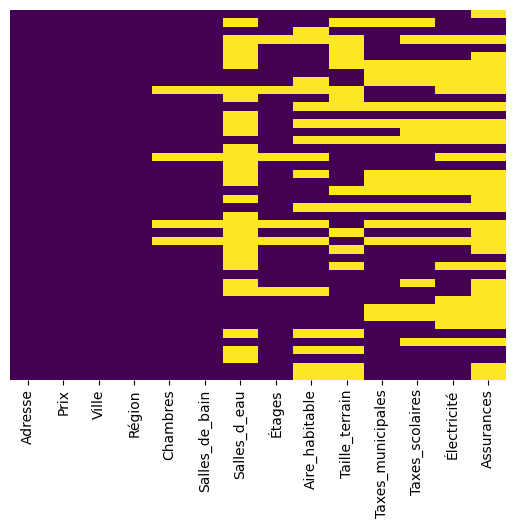

In [43]:
#Q1Combien ya-t-il de valeurs manquantes dans chaque colonne de votre jeu
#de donn´ees?
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap="viridis")
import numpy as np
print(df.isnull().sum())


Q2)la cause des valeurs manqants: des erreurs de frappe, des informations manquantes des imprécisions
,l'utilisateur a oublié de remplir un champ
,Les utilisateurs ont volontairement choisi de ne pas
renseigner un champ lié à leurs convictions sur la manièredont les résultats pourraient être utilisés ou interprétés


In [44]:
#Q3)Combien ya til de r´egions diff´erentes ? et de villes diff´erentes ?

print(df['Région'].unique())
print('-----------------------------------------------------------------------------')
print(df['Ville'].unique())


['Montérégie Ouest' "Montréal / l'Île" 'Mauricie' 'Laurentides'
 'Montérégie (Rive-Sud Montréal)' 'Portneuf' 'Estrie' 'Côte-Nord'
 'Québec Rive-Sud (Lévis)' 'Québec Rive-Nord' 'Bas-Saint-Laurent'
 'Lanaudière' 'Centre-du-Québec' 'Saguenay-Lac-Saint-Jean']
-----------------------------------------------------------------------------
['Vaudreuil-Dorion' 'Rosemont / La Petite Patrie' 'St-Étienne-Des-Gres'
 'Mirabel' 'Côte-des-Neiges / Notre-Dame-de-Grâce'
 'Mercier / Hochelaga / Maisonneuve' 'Brossard' 'St-Hippolyte'
 'Pont-Rouge' 'Eastman' 'Sept-Iles' 'St-Nicolas'
 'Trois-Rivières (Cap-De-La-Madeleine)' 'Lebourgneuf'
 'Rimouski (Rimouski)' 'Stoneham' 'Ste-Julienne' 'St-Pierre-Les-Becquets'
 'Val-des-Sources' 'St-Raymond' 'Ste-Catherine-de-la-JC' 'Mercier'
 'Saint-Laurent' 'Lévis' 'Charlesbourg' 'Noyan' 'Shannon' 'Nantes'
 'Trois-Rivières (Trois-Rivières)' 'St-Émile' 'St-Lin-Laurentides'
 'Neuville' 'Villeray / St-Michel / Parc-Extension'
 'Pierrefonds / Roxboro' 'St-Albert' 'St-Sauveur' 

In [45]:
#Q4)Quel est le type (inf´er´e par pandas) de donn´ees de chaque colonne ?

print(df.dtypes)
print(df.dtypes.value_counts())

Adresse               object
Prix                  object
Ville                 object
Région                object
Chambres             float64
Salles_de_bain       float64
Salles_d_eau         float64
Étages               float64
Aire_habitable       float64
Taille_terrain       float64
Taxes_municipales    float64
Taxes_scolaires      float64
Électricité          float64
Assurances           float64
dtype: object
float64    10
object      4
dtype: int64


In [46]:
#Q5)Nettoyer vos donn´ees : correction d’erreurs, traitement de valeurs 
#manquantes s’il ya lieu, correction du type des donn
def detect_string(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

df["Prix"] = df["Prix"].apply(lambda x: detect_string(x))
print(df["Prix"])

0     1000000.0
1      619000.0
2      549000.0
3     1100000.0
4      594000.0
5      499000.0
6      366900.0
7      590000.0
8      325000.0
9      109000.0
10     225000.0
11     360000.0
12     229000.0
13     449400.0
14     549000.0
15     429000.0
16     234000.0
17     139000.0
18     259000.0
19     247000.0
20     326500.0
21     439000.0
22     559000.0
23     495000.0
24     375000.0
25     345000.0
26     279500.0
27      99500.0
28     234500.0
29     397000.0
30    1050000.0
31     460000.0
32     565000.0
33    1039000.0
34     850000.0
35     358900.0
36          NaN
37     785000.0
38     200000.0
39     399900.0
40     274000.0
41     175000.0
42    1500000.0
43     809000.0
Name: Prix, dtype: float64


In [47]:

df["Prix"].fillna(df["Prix"].median(), inplace=True)
df

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances
0,"348, rue Maurice-Richard",1000000.0,Vaudreuil-Dorion,Montérégie Ouest,4.0,3.0,1.0,2.0,2000.0,12152.0,631000.0,67400.0,720000.0,NaN
1,"6339, RUE DES ÉCORES",619000.0,Rosemont / La Petite Patrie,Montréal / l'Île,2.0,1.0,NaN,1.0,995.0,NaN,NaN,NaN,197100.0,164300.0
2,"220, rue François-Chrétien",549000.0,St-Étienne-Des-Gres,Mauricie,3.0,2.0,1.0,1.0,NaN,37923.0,416800.0,26700.0,92600.0,176100.0
3,"12275-12277-12279, rue Félix-l'Allier",1100000.0,Mirabel,Laurentides,3.0,1.0,NaN,NaN,NaN,NaN,328300.0,NaN,NaN,NaN
4,"5569, avenue McLynn",594000.0,Côte-des-Neiges / Notre-Dame-de-Grâce,Montréal / l'Île,3.0,1.0,NaN,1.0,1018.0,NaN,129898.0,16150.0,60000.0,48313.0
5,"2023, avenue Lebrun",499000.0,Mercier / Hochelaga / Maisonneuve,Montréal / l'Île,2.0,1.0,NaN,1.0,900.0,NaN,250000.0,30000.0,100000.0,NaN
6,Boulevard Taschereau- Unité 311- Georges Henri...,366900.0,Brossard,Montérégie (Rive-Sud Montréal),1.0,1.0,NaN,1.0,661.0,NaN,NaN,NaN,NaN,NaN
7,"18, rue des Cépages- Projet domiciliaire Mont ...",590000.0,St-Hippolyte,Laurentides,3.0,1.0,1.0,2.0,1370.0,61356.0,NaN,NaN,NaN,NaN
8,"0, Développement AUBE - Par Construction Mario...",325000.0,Pont-Rouge,Portneuf,3.0,1.0,1.0,2.0,NaN,6000.0,NaN,NaN,NaN,NaN
9,chemin Gilbert,109000.0,Eastman,Estrie,NaN,NaN,NaN,NaN,NaN,NaN,33146.0,3099.0,NaN,NaN


In [48]:
# Corriger les erreurs de formatage du adresse
df['Adresse']=df['Adresse'].str.replace(',','')
df

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances
0,348 rue Maurice-Richard,1000000.0,Vaudreuil-Dorion,Montérégie Ouest,4.0,3.0,1.0,2.0,2000.0,12152.0,631000.0,67400.0,720000.0,NaN
1,6339 RUE DES ÉCORES,619000.0,Rosemont / La Petite Patrie,Montréal / l'Île,2.0,1.0,NaN,1.0,995.0,NaN,NaN,NaN,197100.0,164300.0
2,220 rue François-Chrétien,549000.0,St-Étienne-Des-Gres,Mauricie,3.0,2.0,1.0,1.0,NaN,37923.0,416800.0,26700.0,92600.0,176100.0
3,12275-12277-12279 rue Félix-l'Allier,1100000.0,Mirabel,Laurentides,3.0,1.0,NaN,NaN,NaN,NaN,328300.0,NaN,NaN,NaN
4,5569 avenue McLynn,594000.0,Côte-des-Neiges / Notre-Dame-de-Grâce,Montréal / l'Île,3.0,1.0,NaN,1.0,1018.0,NaN,129898.0,16150.0,60000.0,48313.0
5,2023 avenue Lebrun,499000.0,Mercier / Hochelaga / Maisonneuve,Montréal / l'Île,2.0,1.0,NaN,1.0,900.0,NaN,250000.0,30000.0,100000.0,NaN
6,Boulevard Taschereau- Unité 311- Georges Henri...,366900.0,Brossard,Montérégie (Rive-Sud Montréal),1.0,1.0,NaN,1.0,661.0,NaN,NaN,NaN,NaN,NaN
7,18 rue des Cépages- Projet domiciliaire Mont d...,590000.0,St-Hippolyte,Laurentides,3.0,1.0,1.0,2.0,1370.0,61356.0,NaN,NaN,NaN,NaN
8,0 Développement AUBE - Par Construction Mario ...,325000.0,Pont-Rouge,Portneuf,3.0,1.0,1.0,2.0,NaN,6000.0,NaN,NaN,NaN,NaN
9,chemin Gilbert,109000.0,Eastman,Estrie,NaN,NaN,NaN,NaN,NaN,NaN,33146.0,3099.0,NaN,NaN


In [49]:
df["Chambres"].fillna(df["Chambres"].median(), inplace=True)
df["Salles_de_bain"].fillna(df["Salles_de_bain"].median(), inplace=True)
df["Salles_d_eau"].fillna(df["Salles_d_eau"].median(), inplace=True)
df["Étages"].fillna(df["Étages"].median(), inplace=True)
df["Aire_habitable"].fillna(df["Aire_habitable"].mean(), inplace=True)
df["Taille_terrain"].fillna(df["Taille_terrain"].mean(), inplace=True)
df["Taxes_municipales"].fillna(df["Taxes_municipales"].median(), inplace=True)
df["Taxes_scolaires"].fillna(df["Taxes_scolaires"].median(), inplace=True)
df["Électricité"].fillna(df["Électricité"].median(), inplace=True)
df["Assurances"].fillna(df["Assurances"].median(), inplace=True)
df

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances
0,348 rue Maurice-Richard,1000000.0,Vaudreuil-Dorion,Montérégie Ouest,4.0,3.0,1.0,2.0,2000.000000,12152.0,631000.0,67400.0,720000.0,120000.0
1,6339 RUE DES ÉCORES,619000.0,Rosemont / La Petite Patrie,Montréal / l'Île,2.0,1.0,1.0,1.0,995.000000,20360.2,285249.0,26897.0,197100.0,164300.0
2,220 rue François-Chrétien,549000.0,St-Étienne-Des-Gres,Mauricie,3.0,2.0,1.0,1.0,1226.703704,37923.0,416800.0,26700.0,92600.0,176100.0
3,12275-12277-12279 rue Félix-l'Allier,1100000.0,Mirabel,Laurentides,3.0,1.0,1.0,1.5,1226.703704,20360.2,328300.0,26897.0,123000.0,120000.0
4,5569 avenue McLynn,594000.0,Côte-des-Neiges / Notre-Dame-de-Grâce,Montréal / l'Île,3.0,1.0,1.0,1.0,1018.000000,20360.2,129898.0,16150.0,60000.0,48313.0
5,2023 avenue Lebrun,499000.0,Mercier / Hochelaga / Maisonneuve,Montréal / l'Île,2.0,1.0,1.0,1.0,900.000000,20360.2,250000.0,30000.0,100000.0,120000.0
6,Boulevard Taschereau- Unité 311- Georges Henri...,366900.0,Brossard,Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,661.000000,20360.2,285249.0,26897.0,123000.0,120000.0
7,18 rue des Cépages- Projet domiciliaire Mont d...,590000.0,St-Hippolyte,Laurentides,3.0,1.0,1.0,2.0,1370.000000,61356.0,285249.0,26897.0,123000.0,120000.0
8,0 Développement AUBE - Par Construction Mario ...,325000.0,Pont-Rouge,Portneuf,3.0,1.0,1.0,2.0,1226.703704,6000.0,285249.0,26897.0,123000.0,120000.0
9,chemin Gilbert,109000.0,Eastman,Estrie,3.0,1.0,1.0,1.5,1226.703704,20360.2,33146.0,3099.0,123000.0,120000.0


In [50]:
# # Éliminer les valeurs aberrantes catégoriques"Adresse"
# def calcul_frequence(x, table_frequence):
#     return table_frequence[x]

# table_frequence = df["Adresse"].value_counts() 
# index = df["Adresse"].apply(lambda x : calcul_frequence(x, table_frequence)) > 1 
# df = df[index]
# print(df)

In [51]:
# # Éliminer les valeurs aberrantes catégoriques"Région"
# def calcul_frequence(x, table_frequence):
#     return table_frequence[x]

# table_frequence = df["Région"].value_counts() 
# index = df["Région"].apply(lambda x : calcul_frequence(x, table_frequence)) > 1 
# df = df[index]
# print(df)
# print(table_frequence)

In [52]:
# # Éliminer les valeurs aberrantes catégoriques"Ville"
# def calcul_frequence(x, table_frequence):
#     return table_frequence[x]

# table_frequence = df["Ville"].value_counts() 
# index = df["Ville"].apply(lambda x : calcul_frequence(x, table_frequence)) > 1 
# df = df[index]
# print(df)

In [53]:
# # Éliminer les valeurs aberrantes numériques column"Aire_habitable"
# Q1 = df["Aire_habitable"].quantile(0.25)
# Q3 = df["Aire_habitable"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Aire_habitable"] > (Q3 + 1.5 * IQR)
# min = df["Aire_habitable"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)

In [54]:
# # Éliminer les valeurs aberrantes numériques column 'Taille_terrain'
# Q1 = df["Taille_terrain"].quantile(0.25)
# Q3 = df["Taille_terrain"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Taille_terrain"] > (Q3 + 1.5 * IQR)
# min = df["Taille_terrain"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)

In [55]:
# # Éliminer les valeurs aberrantes numériques column 'Taxes_municipales'
# Q1 = df["Taxes_municipales"].quantile(0.25)
# Q3 = df["Taxes_municipales"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Taxes_municipales"] > (Q3 + 1.5 * IQR)
# min = df["Taxes_municipales"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)

In [56]:
# # Éliminer les valeurs aberrantes numériques column 'Taxes_scolaires'
# Q1 = df["Taxes_scolaires"].quantile(0.25)
# Q3 = df["Taxes_scolaires"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Taxes_scolaires"] > (Q3 + 1.5 * IQR)
# min = df["Taxes_scolaires"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)
# len(df)
df

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances
0,348 rue Maurice-Richard,1000000.0,Vaudreuil-Dorion,Montérégie Ouest,4.0,3.0,1.0,2.0,2000.000000,12152.0,631000.0,67400.0,720000.0,120000.0
1,6339 RUE DES ÉCORES,619000.0,Rosemont / La Petite Patrie,Montréal / l'Île,2.0,1.0,1.0,1.0,995.000000,20360.2,285249.0,26897.0,197100.0,164300.0
2,220 rue François-Chrétien,549000.0,St-Étienne-Des-Gres,Mauricie,3.0,2.0,1.0,1.0,1226.703704,37923.0,416800.0,26700.0,92600.0,176100.0
3,12275-12277-12279 rue Félix-l'Allier,1100000.0,Mirabel,Laurentides,3.0,1.0,1.0,1.5,1226.703704,20360.2,328300.0,26897.0,123000.0,120000.0
4,5569 avenue McLynn,594000.0,Côte-des-Neiges / Notre-Dame-de-Grâce,Montréal / l'Île,3.0,1.0,1.0,1.0,1018.000000,20360.2,129898.0,16150.0,60000.0,48313.0
5,2023 avenue Lebrun,499000.0,Mercier / Hochelaga / Maisonneuve,Montréal / l'Île,2.0,1.0,1.0,1.0,900.000000,20360.2,250000.0,30000.0,100000.0,120000.0
6,Boulevard Taschereau- Unité 311- Georges Henri...,366900.0,Brossard,Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,661.000000,20360.2,285249.0,26897.0,123000.0,120000.0
7,18 rue des Cépages- Projet domiciliaire Mont d...,590000.0,St-Hippolyte,Laurentides,3.0,1.0,1.0,2.0,1370.000000,61356.0,285249.0,26897.0,123000.0,120000.0
8,0 Développement AUBE - Par Construction Mario ...,325000.0,Pont-Rouge,Portneuf,3.0,1.0,1.0,2.0,1226.703704,6000.0,285249.0,26897.0,123000.0,120000.0
9,chemin Gilbert,109000.0,Eastman,Estrie,3.0,1.0,1.0,1.5,1226.703704,20360.2,33146.0,3099.0,123000.0,120000.0


In [57]:
# # Éliminer les valeurs aberrantes numériques column 'Électricité'
# Q1 = df["Électricité"].quantile(0.25)
# Q3 = df["Électricité"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Électricité"] > (Q3 + 1.5 * IQR)
# min = df["Électricité"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)

In [58]:
# # Éliminer les valeurs aberrantes numériques column 'Assurances'
# Q1 = df["Assurances"].quantile(0.25)
# Q3 = df["Assurances"].quantile(0.75)
# IQR = Q3 - Q1
# max = df["Assurances"] > (Q3 + 1.5 * IQR)
# min = df["Assurances"] < (Q1 - 1.5 * IQR)
# index = ~(max | min)
# df = df[index]
# print(df)

In [59]:
#Q6 Quel est le prix moyen des maisons (au moins 1 chambre et 1 salle debain) sur l’ˆıle de Montr´eal ? A Laval ? Dans les laurentides ?
Prix_moy_montreal = df.loc[(df['Chambres'] >= 1.0) & (df['Salles_de_bain'] == 1.0) &  ((df['Région'] == "Montréal / l'Île") )]
Prix_moy_montreal = Prix_moy_montreal['Prix'].mean()
print("prix moyenne montreal",Prix_moy_montreal)
Prix_moy_laval = df.loc[(df['Chambres'] >= 1.0) & (df['Salles_de_bain'] == 1.0) &  ((df['Région'] == "Laval") )]
Prix_moy_laval = Prix_moy_laval['Prix'].mean()
print('prix moyenne laval',Prix_moy_laval)
Prix_moy_Laurentides = df.loc[(df['Chambres'] >= 1.0) & (df['Salles_de_bain'] == 1.0) &  ((df['Région'] == "Laurentides") )]
Prix_moy_Laurentides = Prix_moy_Laurentides['Prix'].mean()
print('prix moyenne Laurentides',Prix_moy_Laurentides)

prix moyenne montreal 850200.0
prix moyenne laval nan
prix moyenne Laurentides 845000.0


In [60]:
#Q7Dans quelle ville de Montr´eal/l’ˆIle les maisons (au moins 1 chambre et 1
#salle de bain) coˆutent le moins chers ?
Prix_ville = df.loc[(df['Chambres'] >= 1.0) & (df['Salles_de_bain'] == 1.0) & ((df['Région'] == "Montréal / l'Île") )]
Prix_ville_min = Prix_ville['Prix'].min()
#Prix_ville_moincher = Prix_ville_moincher.loc[(Prix_ville_moincher['Ville'] == Prix_ville_moincher['Prix'].min())]
#Prix_ville_moincher = Prix_ville_moincher.loc[(Prix_ville_moincher['Ville'] == (Prix_ville_moincher['Prix']).min())]
#Prix_ville_moincher = Prix_ville[~Prix_ville['Prix'].isin([209000.0])]
Prix_ville_moincher = Prix_ville.loc[Prix_ville.apply(lambda x: x.Prix in [Prix_ville_min], axis=1)]
#Prix_ville_moincher = Prix_ville.groupby(['Ville'])['Prix'].nsmallest()
#pd.set_option('display.max_rows',None)
Prix_ville_moincher['Ville']

5    Mercier / Hochelaga / Maisonneuve
Name: Ville, dtype: object

In [61]:
#Q8)Pour chaque r´egion, afficher le prix de l’item (annonce) le plus ´elev´e et
#la ville o`u l’item se situe. Ici on ne fait pas de diff´erence si c’est un
#condo/appartement, maison, terrain vide, etc. A quel r´egion/ville revient
#la palme d’or de l’item le plus cher ? Donner toutes les caract´eristiques
#(valeurs de toutes les colonnes) de cet item.
#df[['Région','Prix']]
Prix_eleve = df.groupby(['Région','Ville']).agg({'Prix':['max']})
Prix_eleve.columns = ['Prix_max'] 
Prix_eleve

Prix_max
Région                         Ville                                           
Bas-Saint-Laurent              Rimouski (Rimouski)                     549000.0
Centre-du-Québec               St-Albert                               399900.0
                               St-Pierre-Les-Becquets                  139000.0
Côte-Nord                      Sept-Iles                               225000.0
Estrie                         Bromont                                 809000.0
                               Coaticook                               200000.0
                               Eastman                                 109000.0
                               Nantes                                   99500.0
                               Val-des-Sources                         259000.0
Lanaudière                     St-Lin-Laurentides                      460000.0
                               Ste-Julienne                            234000.0
                               Terrebonne (Terrebonne)                 175000.0
Laurentides                    Mirabel                                1100000.0
                               St-Hippolyte                            590000.0
                               St-Sauveur                              785000.0
Mauricie                       St-Étienne-Des-Gres                     549000.0
                               Trois-Rivières (Cap-De-La-Madeleine)    229000.0
                               Trois-Rivières (Trois-Rivières)         234500.0
Montréal / l'Île               Ahuntsic / Cartierville                1500000.0
                               Côte-des-Neiges / Notre-Dame-de-Grâce  1050000.0
                               Mercier / Hochelaga / Maisonneuve       499000.0
                               Pierrefonds / Roxboro                   850000.0
                               Rosemont / La Petite Patrie             619000.0
                               Saint-Laurent                           559000.0
                               Villeray / St-Michel / Parc-Extension  1039000.0
Montérégie (Rive-Sud Montréal) Brossard                                366900.0
                               Contrecoeur                             399900.0
                               Mercier                                 439000.0
                               Noyan                                   345000.0
Montérégie Ouest               Vaudreuil-Dorion                       1000000.0
Portneuf                       Neuville                                565000.0
                               Pont-Rouge                              325000.0
                               St-Raymond                              247000.0
Québec Rive-Nord               Charlesbourg                            375000.0
                               Lebourgneuf                             449400.0
                               Shannon                                 279500.0
                               St-Émile                                397000.0
                               Ste-Catherine-de-la-JC                  326500.0
                               Stoneham                                429000.0
Québec Rive-Sud (Lévis)        Lévis                                   495000.0
                               St-Nicolas                              360000.0
Saguenay-Lac-Saint-Jean        Chicoutimi (Chicoutimi)                 274000.0

## Visualisation et analyse des donn´ees (6pts) :


C:\Users\Yough\AppData\Local\Temp\ipykernel_60012\3046534656.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


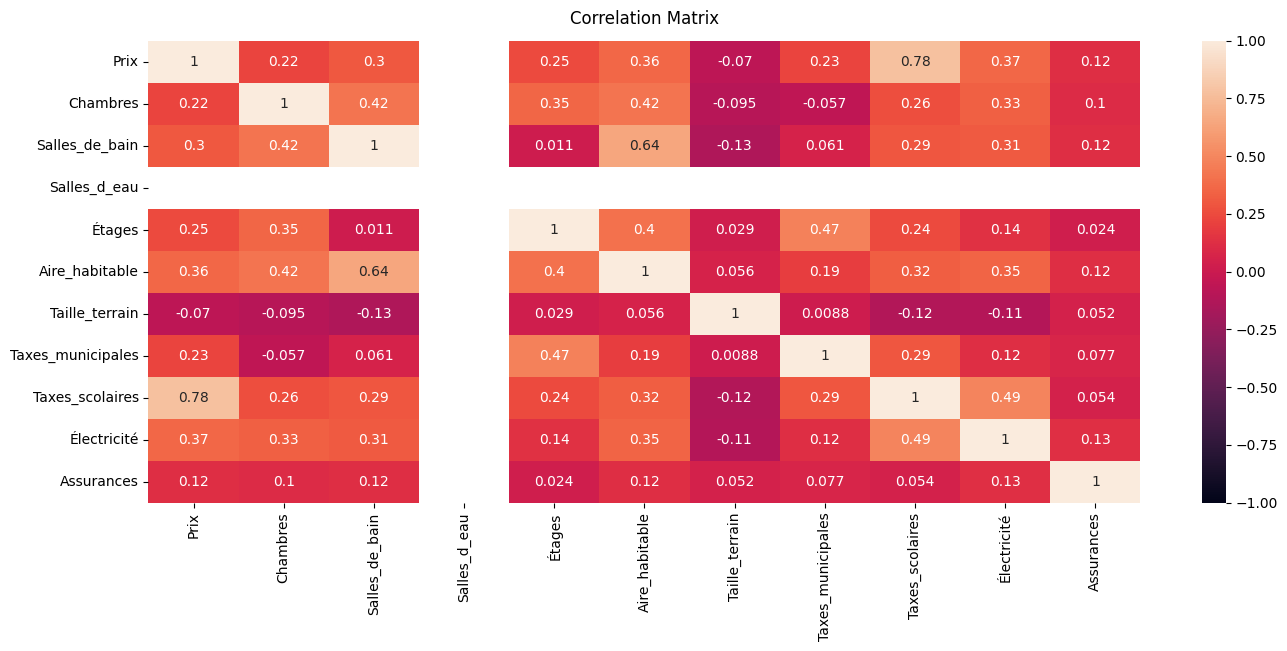

In [62]:
#Q1)

#import matplotlib.pyplot as plt

#rs = np.random.RandomState(0)
#df_plot = pd.DataFrame(rs.rand(10, 10))
#corr = df_plot.corr()
#corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':12}, pad=12);

###### oui on des valeur qui dipasse "0,7" et sont sont les valeur diagonal

Text(0, 0.5, 'nombre d’annonces')

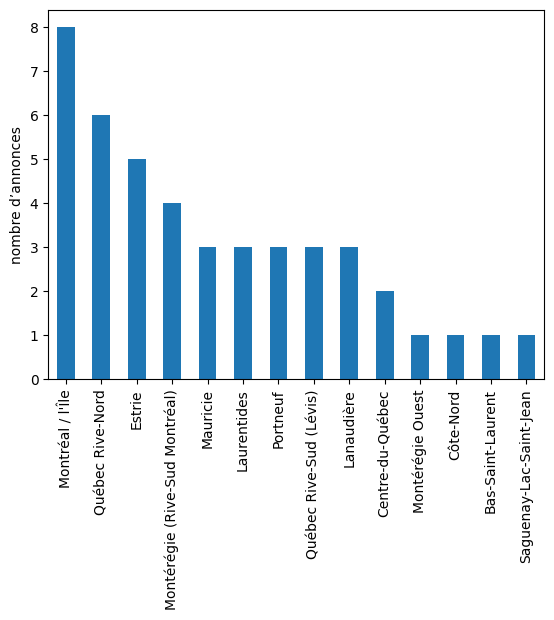

In [63]:
import matplotlib
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt
df_region = df['Région'].value_counts()
#df_region = df.groupby(['Région']).count()
df_region.plot(kind='bar').set_ylabel('nombre d’annonces')


<AxesSubplot: ylabel='Région'>

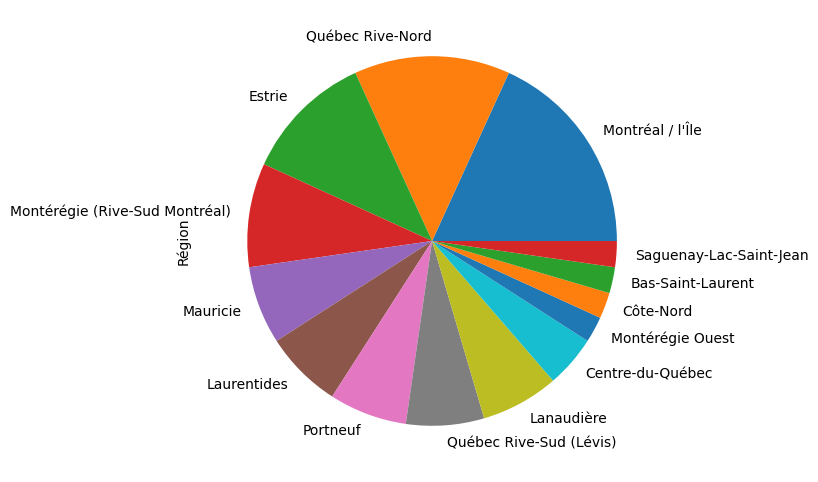

In [64]:
#3. `A l’aide d’un graphique diff´erent de celui de la question pr´ec´edente, comparer
#le nombre d’annonces de vente pour chaque r´egion. Quelle r´egion
#poss`ede le plus d’annonces de vente 
#df_region.plot(kind = 'scatter' ,x = 'Région', figsize = (6,6))
#df_region = df['Région'].value_counts()
df['Région'].value_counts().plot(kind = 'pie', figsize = (6,6))


Text(0, 0.5, 'nombre d’annonces,')

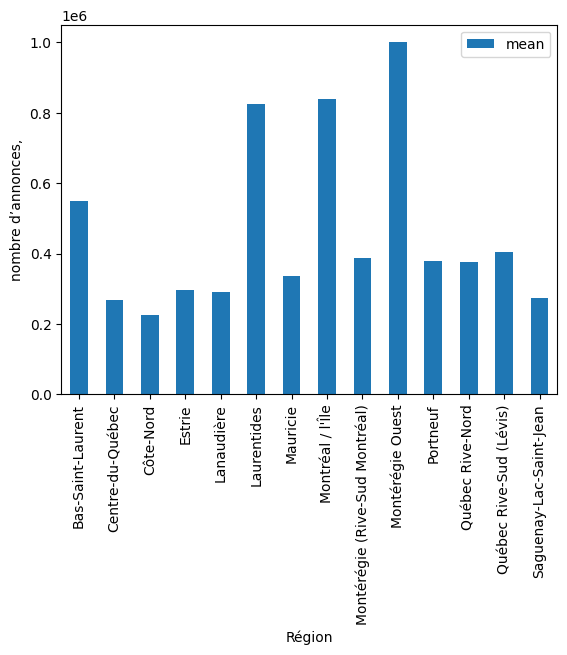

In [65]:
#4. `A l’aide d’un graphique, comparer le prix moyen des annonces pour chaque
#r´egion. Quelle r´egion poss`ede le prix moyen le plus ´elev´e ?
Prix_moy_compar = df.groupby(['Région'])['Prix'].agg(['mean'])
Prix_moy_compar.plot(kind = 'bar').set_ylabel('nombre d’annonces,')

Text(0, 0.5, 'Prix')

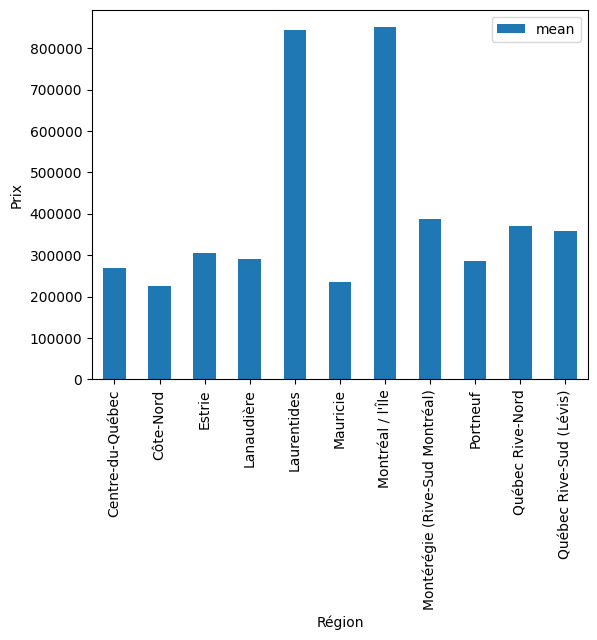

In [66]:
#Q5)Pour ce point, on se limite aux annonces ayant au moins 1 chambre et
#1 salle de bain. `A l’aide d’un graphique, comparer le prix moyen de ces
#annonces pour chaque r´egion. Quelle r´egion poss`ede le prix moyen le plus
#´elev´e pour les annonces avec au moins 1 chambre et 1 salle de bain?
Prix_region = df.loc[(df['Chambres'] >= 1.0) & (df['Salles_de_bain'] == 1.0)]
Prix_region_m = Prix_region.groupby(['Région'])['Prix'].agg(['mean'])
Prix_region_m.plot(kind = 'bar').set_ylabel('Prix')


,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances


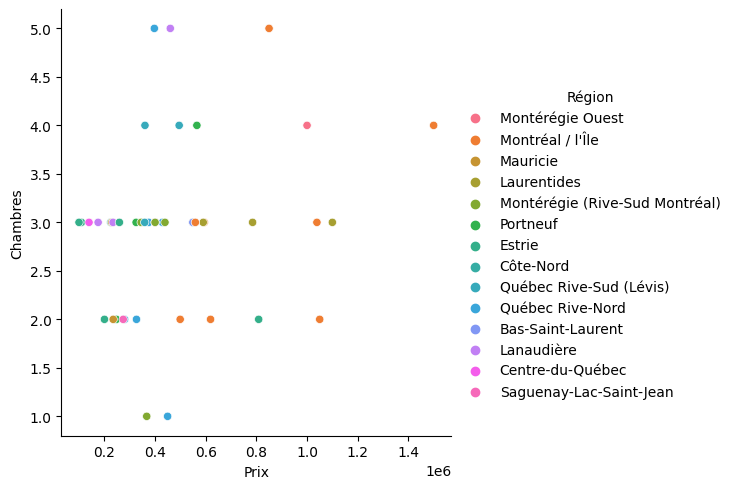

In [67]:
#Q6)`A l’aide d’un graphique, analyser la relation entre le prix des annonces
#et le nombre de chambres. Y a-t-il un lien quelconque ? Est-ce que la
#r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs
#aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes
#de ces valeurs aberrantes.
#df.plot(kind = 'scatter' ,x = 'Prix', y = 'Chambres', figsize = (6,6))
sns.relplot(
    data=df, x="Prix", y="Chambres", hue="Région",
    kind="scatter"
)
df_chambre_aberant = df.loc[(df['Chambres'] >= 15.0) | (df['Prix'] >= 4500000)]
df_chambre_aberant

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances


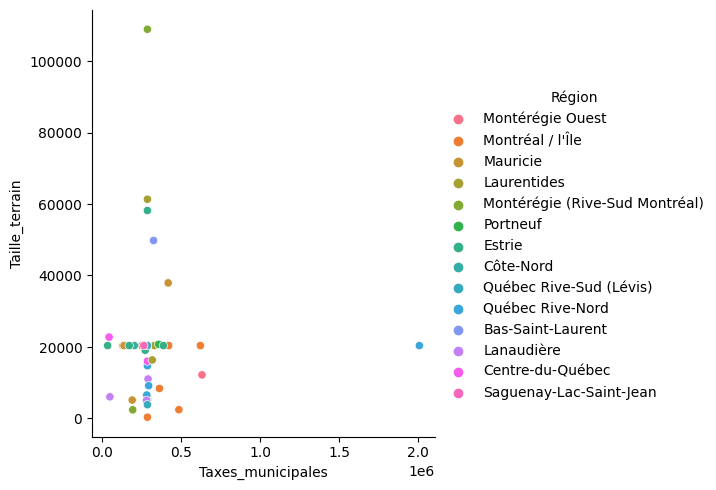

In [68]:
#Q7`A l’aide d’un graphique, analyser la relation entre la valeur des taxes
#municipales annuelles des annonces et la taille du terrain. Y a-t-il un
#lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation?
#Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.
sns.relplot(
    data=df, x="Taxes_municipales", y="Taille_terrain", hue="Région",
    kind="scatter"
)
df_taux_aberant = df.loc[(df['Taxes_municipales'] >= 10000000.0) | (df['Taille_terrain'] >= 200000000.0)]
df_taux_aberant

,Adresse,Prix,Ville,Région,Chambres,Salles_de_bain,Salles_d_eau,Étages,Aire_habitable,Taille_terrain,Taxes_municipales,Taxes_scolaires,Électricité,Assurances


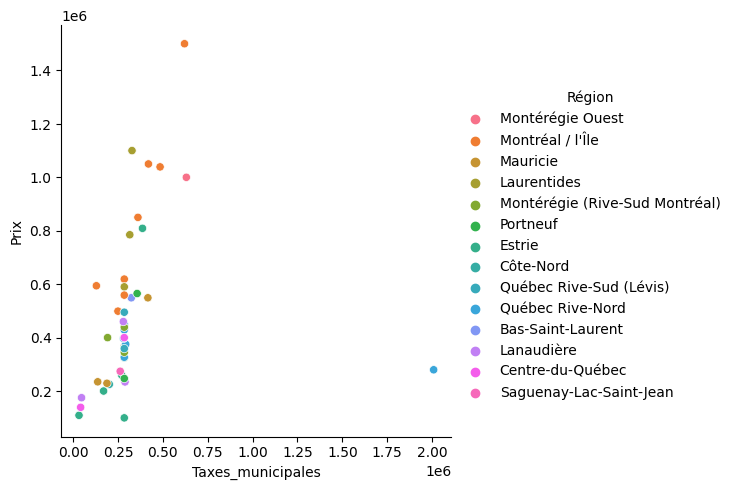

In [69]:
#8)A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales
#annuelles des annonces et le prix. Il y a-t-il un lien quelconque ?
#Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir
#des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs
#des colonnes de ces valeurs aberrantes.
sns.relplot(
    data=df, x="Taxes_municipales", y="Prix", hue="Région",
    kind="scatter"
)
df_taux_aberant = df.loc[(df['Taxes_municipales'] >= 5000000.0) | (df['Prix'] >= 5000000.0)]
df_taux_aberant

<AxesSubplot: xlabel='Prix', ylabel='Région'>

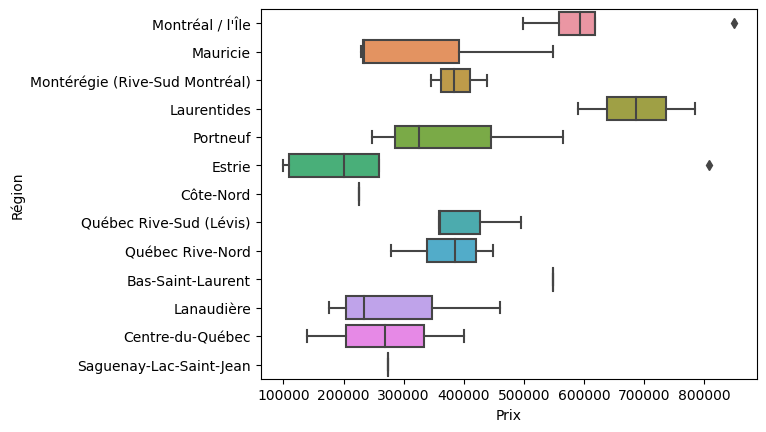

In [70]:
#9. On s’int´eresse pour cette question aux annonces qui ont un prix affich´e
#de moins de 1 million de $, pour toutes les r´egions. Dessiner dans un
#mˆeme graphique un boxplot repr´esentant la r´epartition de prix par r´egion.
#Analyser de mani`ere d´etaill´ee le graphique obtenu.
#?????????????????????????????????????????????????????????????????????????????
df_less_milon = df.loc[(df['Prix'] < 1000000)]
#df_less_milon
sns.boxplot(data=df_less_milon, x='Prix', y='Région')

<AxesSubplot: xlabel='Prix', ylabel='Région'>

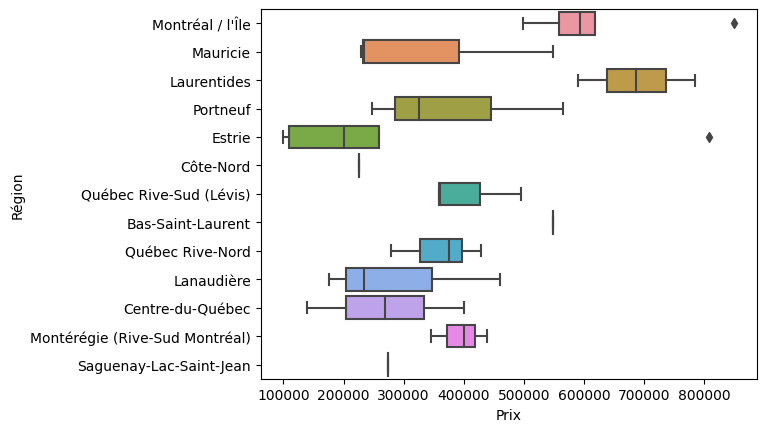

In [71]:
#10On s’int´eresse pour cette question aux maisons de 2 chambres au moins et
#une salle de bain au moins et qui coˆute moins de 1 million de $, pour toutes
#les r´egions. Dessiner dans un mˆeme graphique un boxplot repr´esentant la
#r´epartition de prix par r´egions. Analyser de mani`ere d´etaill´ee le graphique
#obtenu. Est-ce qu’il y a des diff´erences entre ce graphique et celui de la
#question pr´ec´edente ? Si oui donner en 4.
#????????????????????????????????????????????????????????????????????????????????
Prix_Prix = df.loc[(df['Chambres'] >= 2.0) & (df['Salles_de_bain'] >= 1.0) & (df['Prix'] < 1000000)]
sns.boxplot(data=Prix_Prix, x="Prix", y="Région")

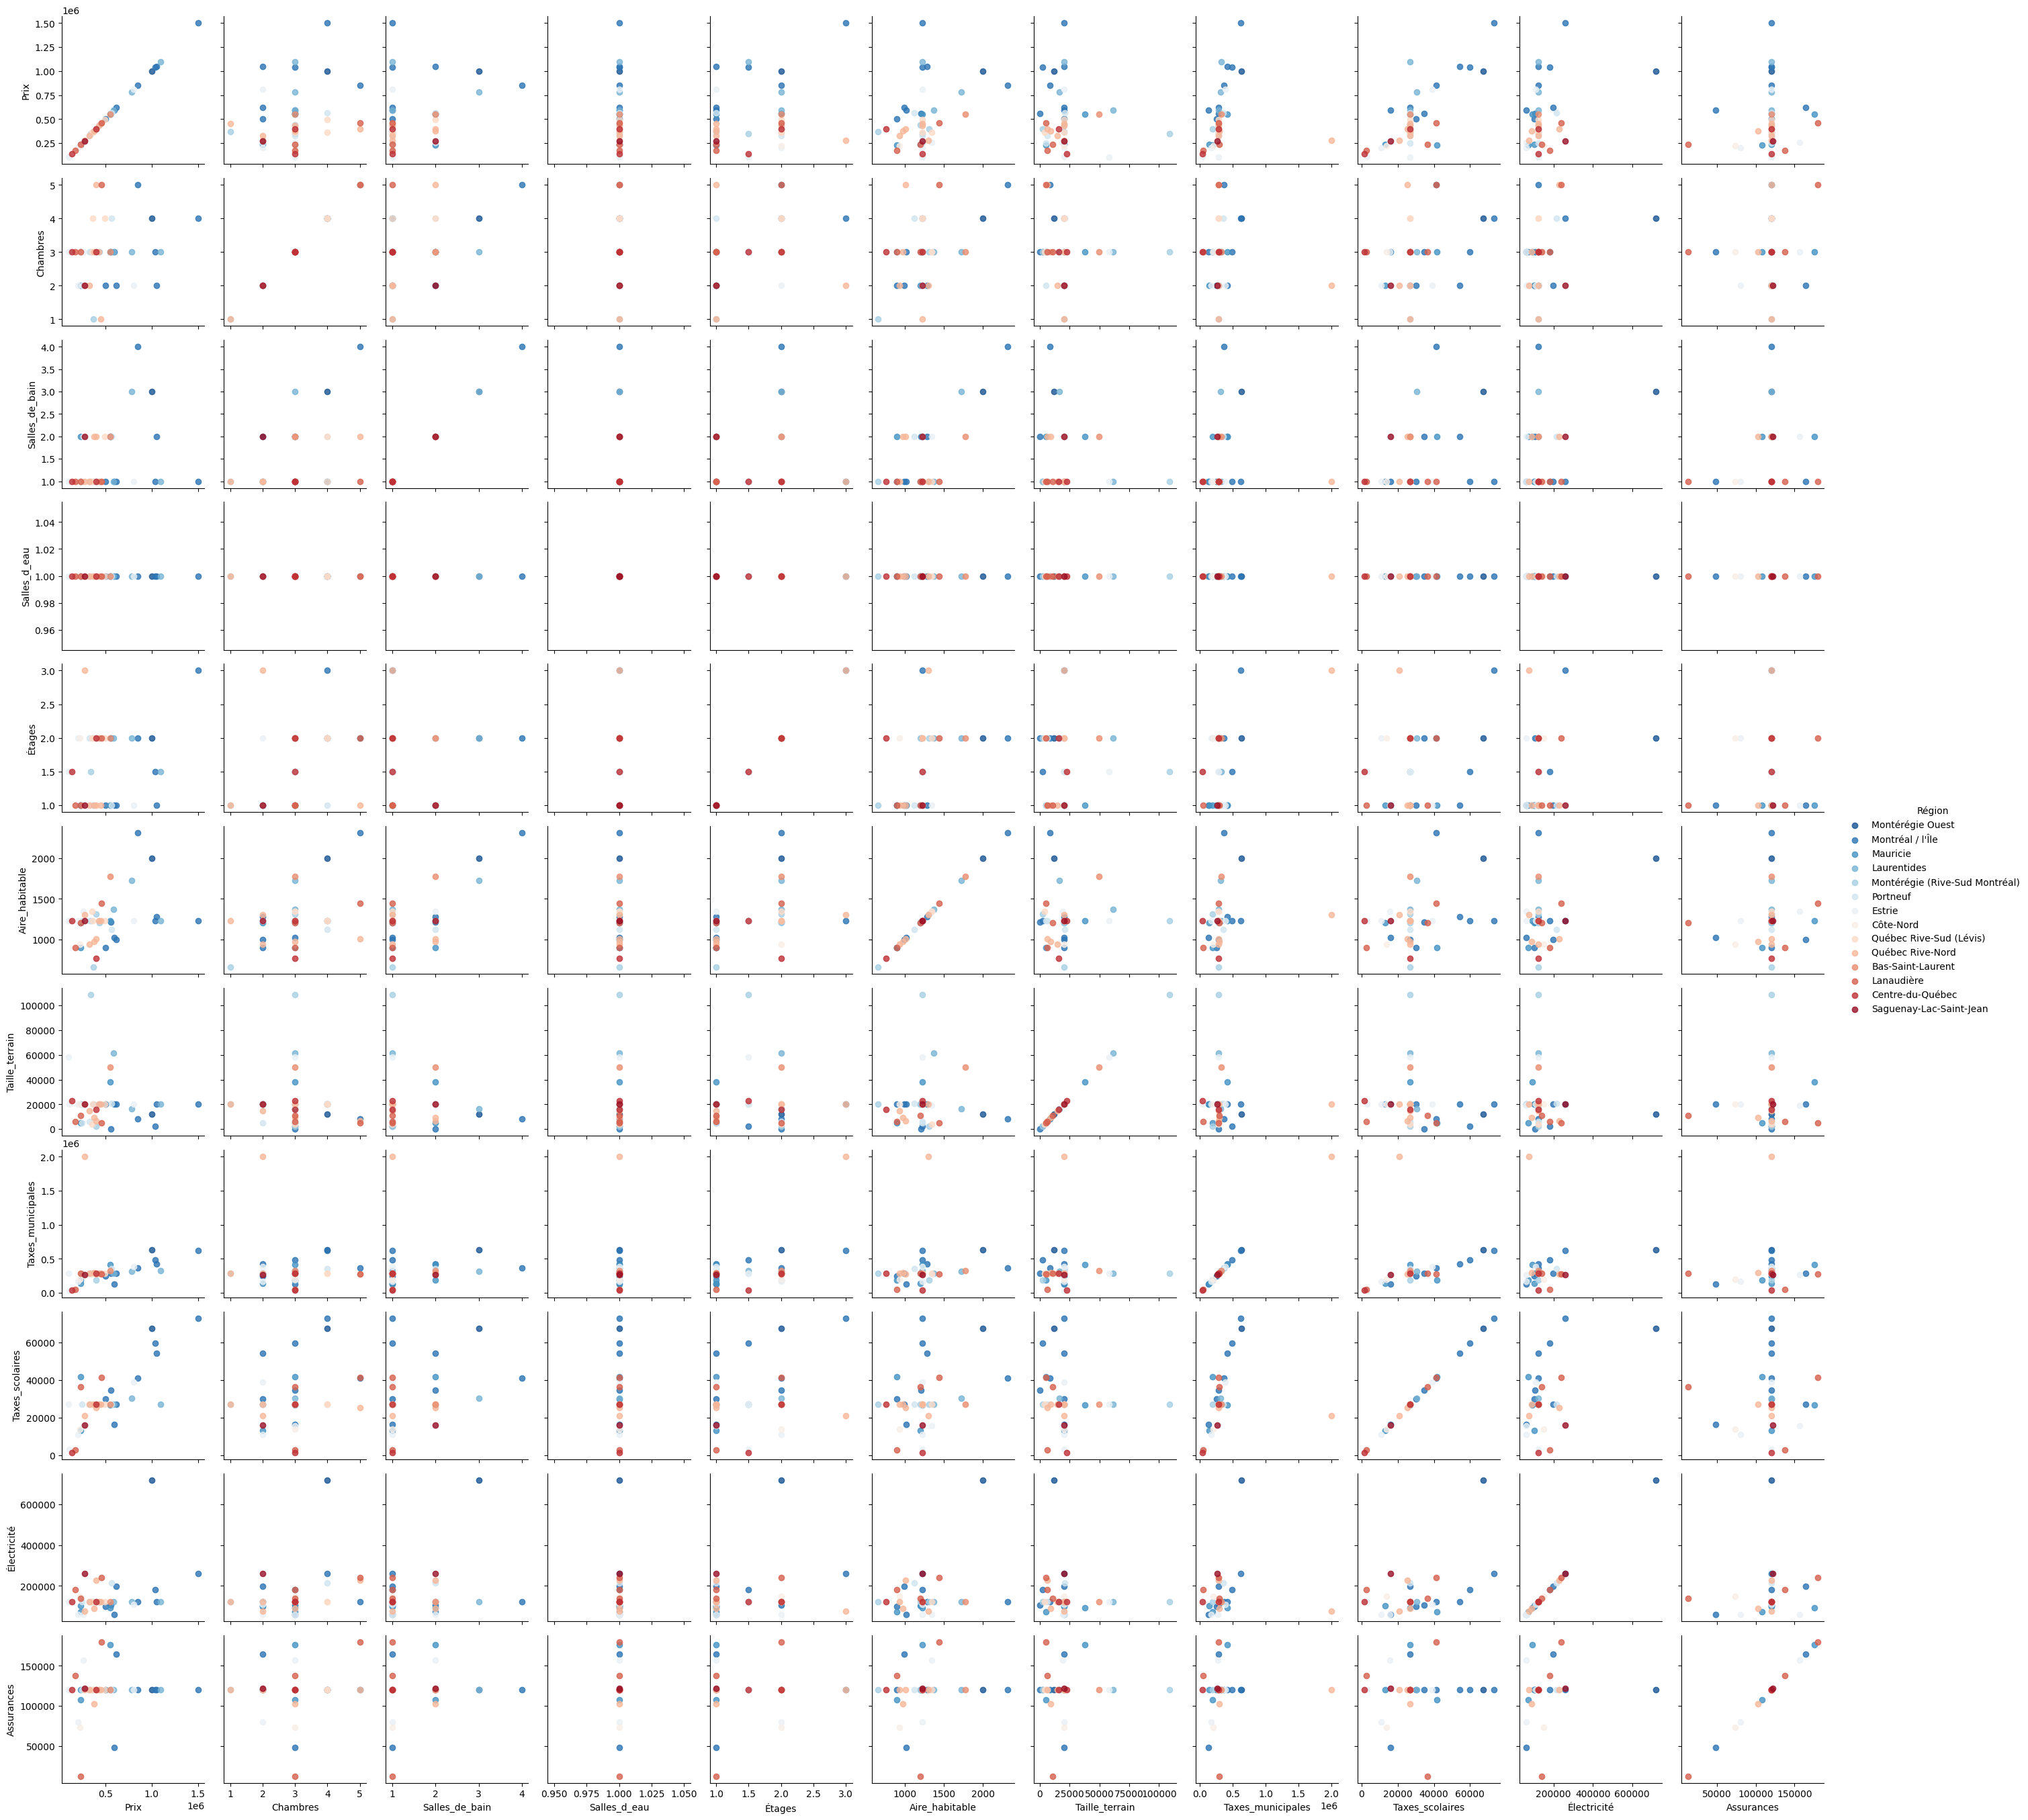

In [72]:
#Q11)En un seul graphique, pr´esenter une analyse bivari´ee de toutes les colonnes
#num´eriques de votre jeu de donn´ees. Analyser en d´etail le graphique
#obtenu.
#?????????????????????????????????????????????????????????????????????????????????
g = sns.PairGrid(df, vars=["Prix","Chambres","Salles_de_bain", "Salles_d_eau", "Étages",\
                  "Aire_habitable","Taille_terrain","Taxes_municipales","Taxes_scolaires","Électricité","Assurances"],
                 hue='Région', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

## 4.4 Algorithmes de r´egression (6pts) :

In [73]:
df.keys()

Index(['Adresse', 'Prix', 'Ville', 'Région', 'Chambres', 'Salles_de_bain',
       'Salles_d_eau', 'Étages', 'Aire_habitable', 'Taille_terrain',
       'Taxes_municipales', 'Taxes_scolaires', 'Électricité', 'Assurances'],
      dtype='object')

C:\Users\Yough\AppData\Local\Temp\ipykernel_60012\3878455290.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrice_corr = df.corr().round(1)


<AxesSubplot: >

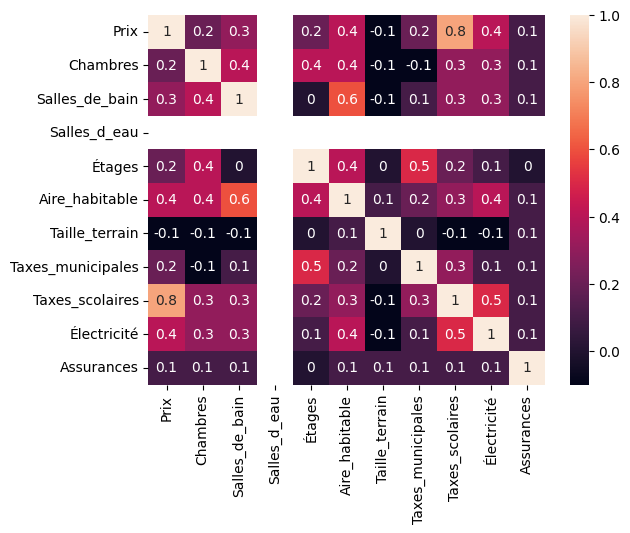

In [74]:
matrice_corr = df.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

In [78]:
#Q1??????????????????????????????????????????????????????????????????
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

x1 = df["Électricité"]
y = df["Prix"]
x = x1.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.15, random_state= 101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, y_train)
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')



(37, 1)
(7, 1)
(37,)
(7,)
La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 285313.6705198938
le score R2 est 0.16559135925009938




In [76]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Entraînement du modèle
model = sm.OLS(y_train, X_train).fit()

# Prédictions
y_pred = model.predict(X_test)

print('Beta_0:', model.params[0])
print('Beta_1:', model.params[1])
model.summary(xname=["beta_0", "beta_1"])


Beta_0: 306850.97275592
Beta_1: 1.2009656640642061


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     6.946
Date:                Tue, 17 Oct 2023   Prob (F-statistic):             0.0124
Time:                        15:02:27   Log-Likelihood:                -517.27
No. Observations:                  37   AIC:                             1039.
Df Residuals:                      35   BIC:                             1042.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
beta_0      3.069e+05   8.05e+04      3.812      0.001    1.43e+05     4.7e+05
beta_1         1.2010      0.456      2.636      0.012       0.276       2.126
==============================================================================
Omnibus:                       14.000   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.466
Skew:                           1.367   Prob(JB):                     0.000722
Kurtosis:                       4.381   Cond. No.                     2.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
def moindre_carres(x, y):
    beta_1 = np.corrcoef(x, y)[0,1] * np.std(y) / np.std(x)
    beta_0 = np.mean(y) - beta_1 * np.mean(x)
    return beta_0, beta_1
beta_0, beta_1 = moindre_carres(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y)
plt.plot(x, beta_1 * x + beta_0, label="sans partitionnement")

model = sm.OLS(y_train, X_train).fit()
plt.plot(x, model.params[1] * x + model.params[0], label="avec partionnement")

# Plot
plt.title('Scatterplot and Correlations')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 44

In [40]:
#Q2Dans cette question, on s’int´eresse `a pr´edire si le prix d’une annonce sera
#sup´erieur ou inf´erieur `a 350000$ en fonction de la r´egion, du nombre de
#chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre
#d’´etages, la superficie de l’aire habitable, la taille du terrain, les taxes
#municipales et les taxes scolaires. Concevez un mod`ele de r´egression qui
#permet de faire cette pr´ediction et ´evaluer votre mod`ele.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
#préparation des données
df_test = df.loc[(df['Prix'] != 350000)]
y = df_test['Prix']
X = df_test[df_test.columns[3:12]]
X_drope = X.drop('Région', axis = 'columns', inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(y_pred)
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='3.0f',cmap="summer")
# plt.title('cm', y=1.05, size=15)

# sns.set(color_codes=True)
# plt.rcParams["figure.figsize"] = [12,12]
# np.random.seed(0)

# #jeu de données sous la forme y = f(x) avec f(x) = x^4 + bx^3 + c
# x = np.random.normal(10, 2, 500)
# y = x ** 4 + np.random.uniform(-1, 1, 500) * (x ** 3) + np.random.uniform(0, 1, 500)
# plt.scatter(x, y)
# plt.show()


C:\Users\Yough\AppData\Local\Temp\ipykernel_65556\1491589322.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_drope = X.drop('Région', axis = 'columns', inplace = True)


[3100000.  440000.  440000. ... 3100000.  440000. 3100000.]
0.014634146341463415
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


C:\Users\Yough\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
#Q3. Dans cette question, on s’int´eresse `a pr´edire le prix d’une annonce en
#fonction de la r´egion, du nombre de chambres, le nombre de salles de
#bain, le nombre de salles d’eau, le nombre d’´etages, la superficie de l’aire
#habitable, la taille du terrain, les taxes municipales et les taxes scolaires.
#Concevez un mod`ele de r´egression qui permet de faire cette pr´ediction et
#´evaluer votre mod`ele.
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#from sklearn.metrics import mean_absolute_error, mean_squared_error
#df_Q = df[df.columns[4:12]]

y = df['Prix']
X = df[df.columns[3:12]]
ct = ColumnTransformer([("Région",OneHotEncoder(),[0])], remainder = "passthrough")
X = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state= 101)

lr = LinearRegression().fit(X_train, y_train)

# Prédictions
y_pred = lr.predict(X_test)

# Evaluation de la performance du modèle
print('Beta_0:', lr.intercept_)
print('Beta_1:', lr.coef_)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

# X_train = sm.add_constant(X_train) 
# X_test = sm.add_constant(X_test)

# # Entraînement du modèle
# model = sm.OLS(y_train, X_train).fit()

# # Prédictions
# y_pred = model.predict(X_test)

# print('Beta_0:', model.params[0])
# print('Beta_1:', model.params[1])
# print('Beta_2:', model.params[2])
# print('Beta_3:', model.params[3])
# model.summary(xname=["beta_0", "beta_1", "beta_2", "beta_3"])

Beta_0: -30620888399.306385
Beta_1: [3.06207239e+10 3.06206943e+10 3.06208898e+10 3.06207830e+10
 3.06207602e+10 3.06206841e+10 3.06209240e+10 3.06207302e+10
 3.06208769e+10 3.06209861e+10 3.06211183e+10 3.06207381e+10
 3.06211679e+10 3.06210345e+10 3.06210934e+10 3.06205434e+10
 3.06209673e+10 3.06208301e+10 3.06208477e+10 3.06208972e+10
 3.06207337e+10 2.57673572e+04 6.02070467e+04 9.62353561e+04
 2.23210256e+03 8.02603262e+01 6.43782746e-05 2.04064406e-01
 9.09665817e-03]
Mean Absolute Error: 201872.3876138868
Mean Squared Error: 163301164643.55124
Mean Root Squared Error: 404105.3880407328


In [ ]:
#Q4 Le couple Formidable aimerait vendre 2 de ses propri´et´es. En vous servant
# de votre mod`ele construit ci-dessus, `a combien est estim´e le prix de vente
# de chacune des deux propri´et´es ? Voici les caract´eristiques :
# • Propri´et´e 1: r´egion: Qu´ebec Rive-Nord, nombre de chambres: 3,
# nombre de salles de bain: 2, nombre de salles d’eau: 1, nombre
# d’´etages: 2, superficie de l’aire habitable: 1700.2 pi2, taille du terrain:
# 5060 pi2, taxes municipales: 4272,39$, taxes scolaires: 411,06$,
# ´electricit´e: 3 584,00 $, assurances 110,38 $.
# • Propri´et´e 2: ville: Ferme-Neuve, r´egion: Laurentides, taille du terrain
# 8021.06 pi2, taxes municipales: 2 324,75 $, taxes scolaires: 65,59$

